In [3]:
#%pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 1.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression



In [9]:

data = pd.read_csv('Loan_Data.csv')
X_data = data.drop(columns=['default'])  # Toutes les colonnes sauf 'default'
y_data = data['default']  # La colonne 'default' est la variable cible
print(data.head())

print(data.info())

   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0      8153374                         0           5221.545193   
1      7442532                         5           1958.928726   
2      2256073                         0           3363.009259   
3      4885975                         0           4766.648001   
4      4700614                         1           1345.827718   

   total_debt_outstanding       income  years_employed  fico_score  default  
0             3915.471226  78039.38546               5         605        0  
1             8228.752520  26648.43525               2         572        1  
2             2027.830850  65866.71246               4         602        0  
3             2501.730397  74356.88347               5         612        0  
4             1768.826187  23448.32631               6         631        0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                 

In [3]:
# Vérifier les valeurs manquantes
print(data.isnull().sum())

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64


In [4]:
# Obtenir les statistiques descriptives
print(data.describe())


        customer_id  credit_lines_outstanding  loan_amt_outstanding  \
count  1.000000e+04              10000.000000          10000.000000   
mean   4.974577e+06                  1.461200           4159.677034   
std    2.293890e+06                  1.743846           1421.399078   
min    1.000324e+06                  0.000000             46.783973   
25%    2.977661e+06                  0.000000           3154.235371   
50%    4.989502e+06                  1.000000           4052.377228   
75%    6.967210e+06                  2.000000           5052.898103   
max    8.999789e+06                  5.000000          10750.677810   

       total_debt_outstanding         income  years_employed    fico_score  \
count            10000.000000   10000.000000    10000.000000  10000.000000   
mean              8718.916797   70039.901401        4.552800    637.557700   
std               6627.164762   20072.214143        1.566862     60.657906   
min                 31.652732    1000.000000    

In [5]:

# Distribution de la variable cible (default)
print(data['default'].value_counts())

default
0    8149
1    1851
Name: count, dtype: int64


Détection des outliers


# Créer un histogramme pour chaque variable numérique


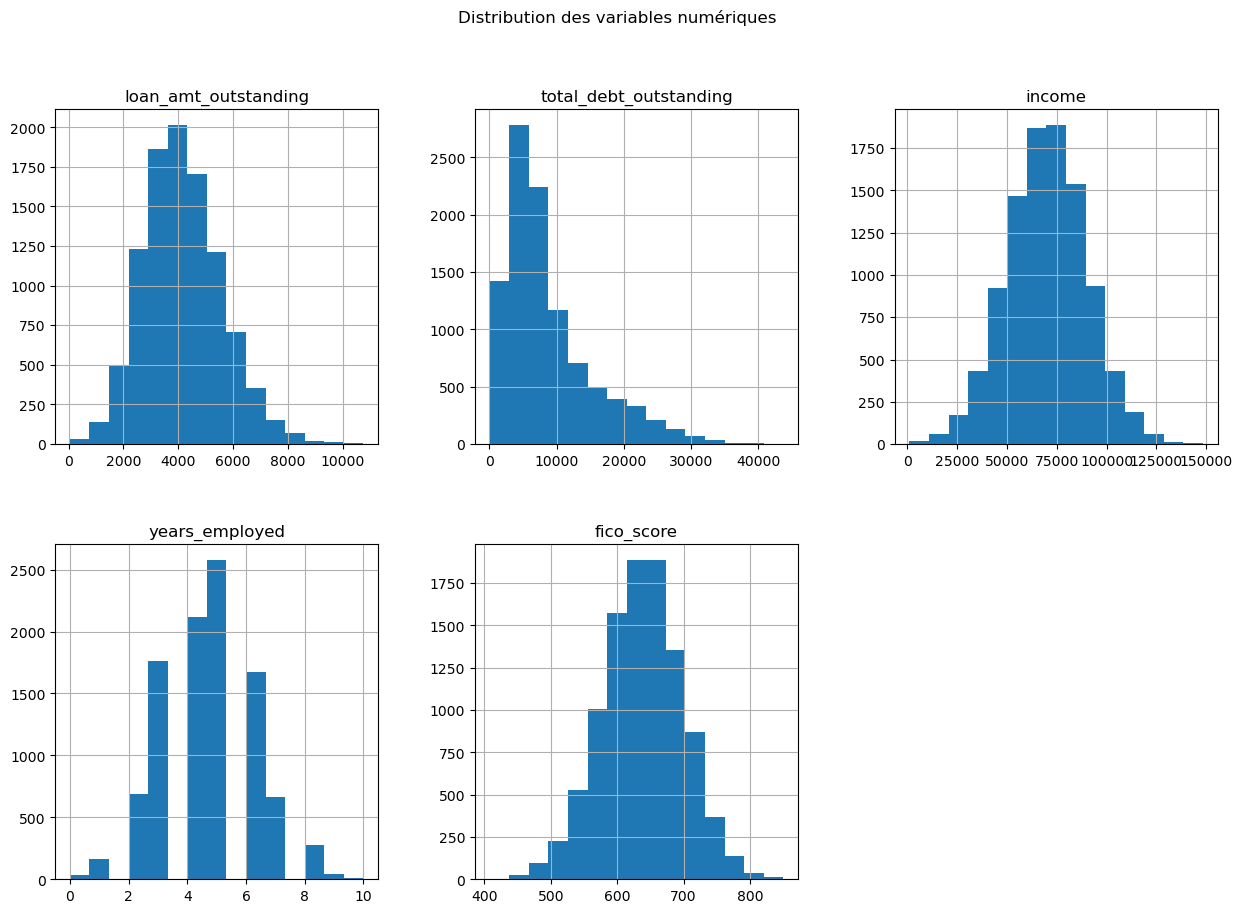

In [11]:
numeric_columns = ['loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']

data[numeric_columns].hist(bins=15, figsize=(15, 10), layout=(2, 3))
plt.suptitle("Distribution des variables numériques")
plt.show()

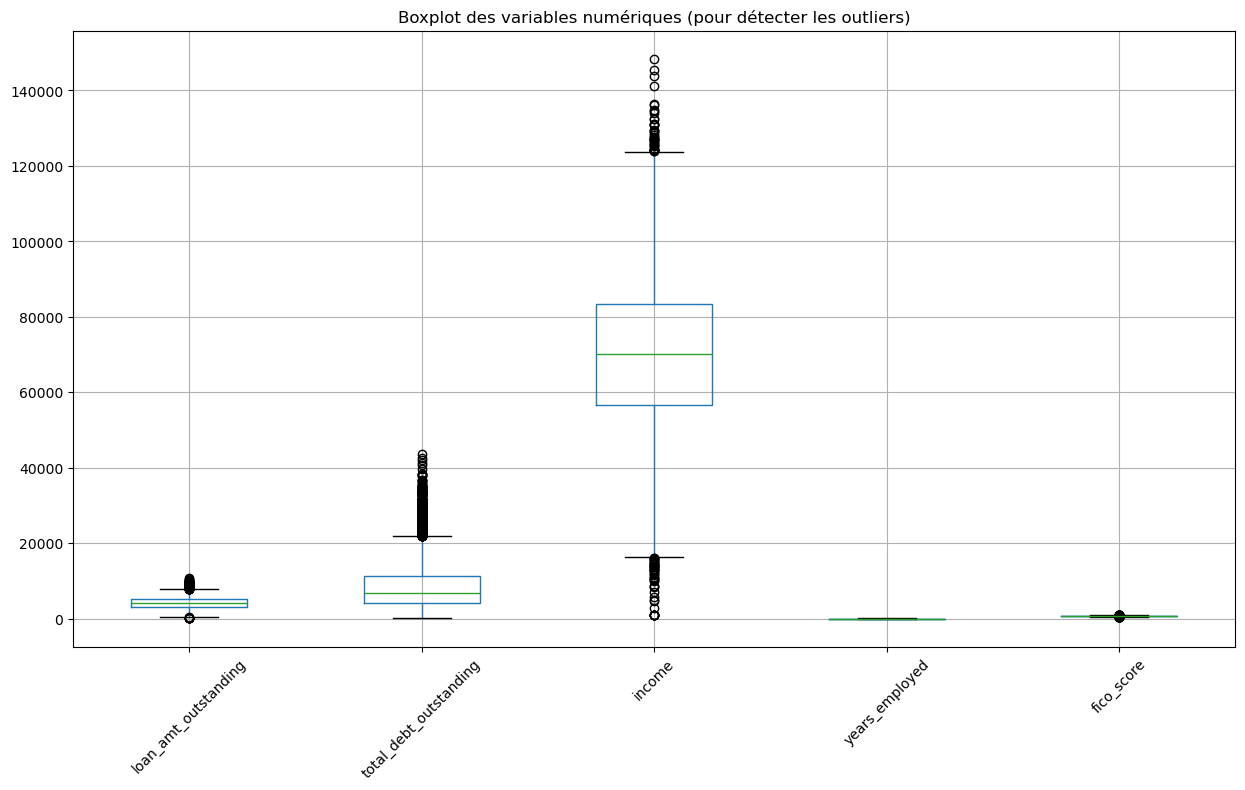

In [12]:
# Créer un boxplot pour chaque variable numérique
plt.figure(figsize=(15, 8))
data[numeric_columns].boxplot()
plt.title("Boxplot des variables numériques (pour détecter les outliers)")
plt.xticks(rotation=45)
plt.show()

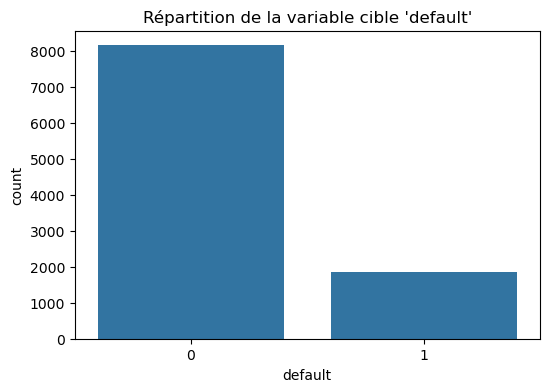

In [15]:
# Créer un diagramme en barres pour la variable 'default'
plt.figure(figsize=(6, 4))
sns.countplot(x='default', data=data)
plt.title("Répartition de la variable cible 'default'")
plt.show()

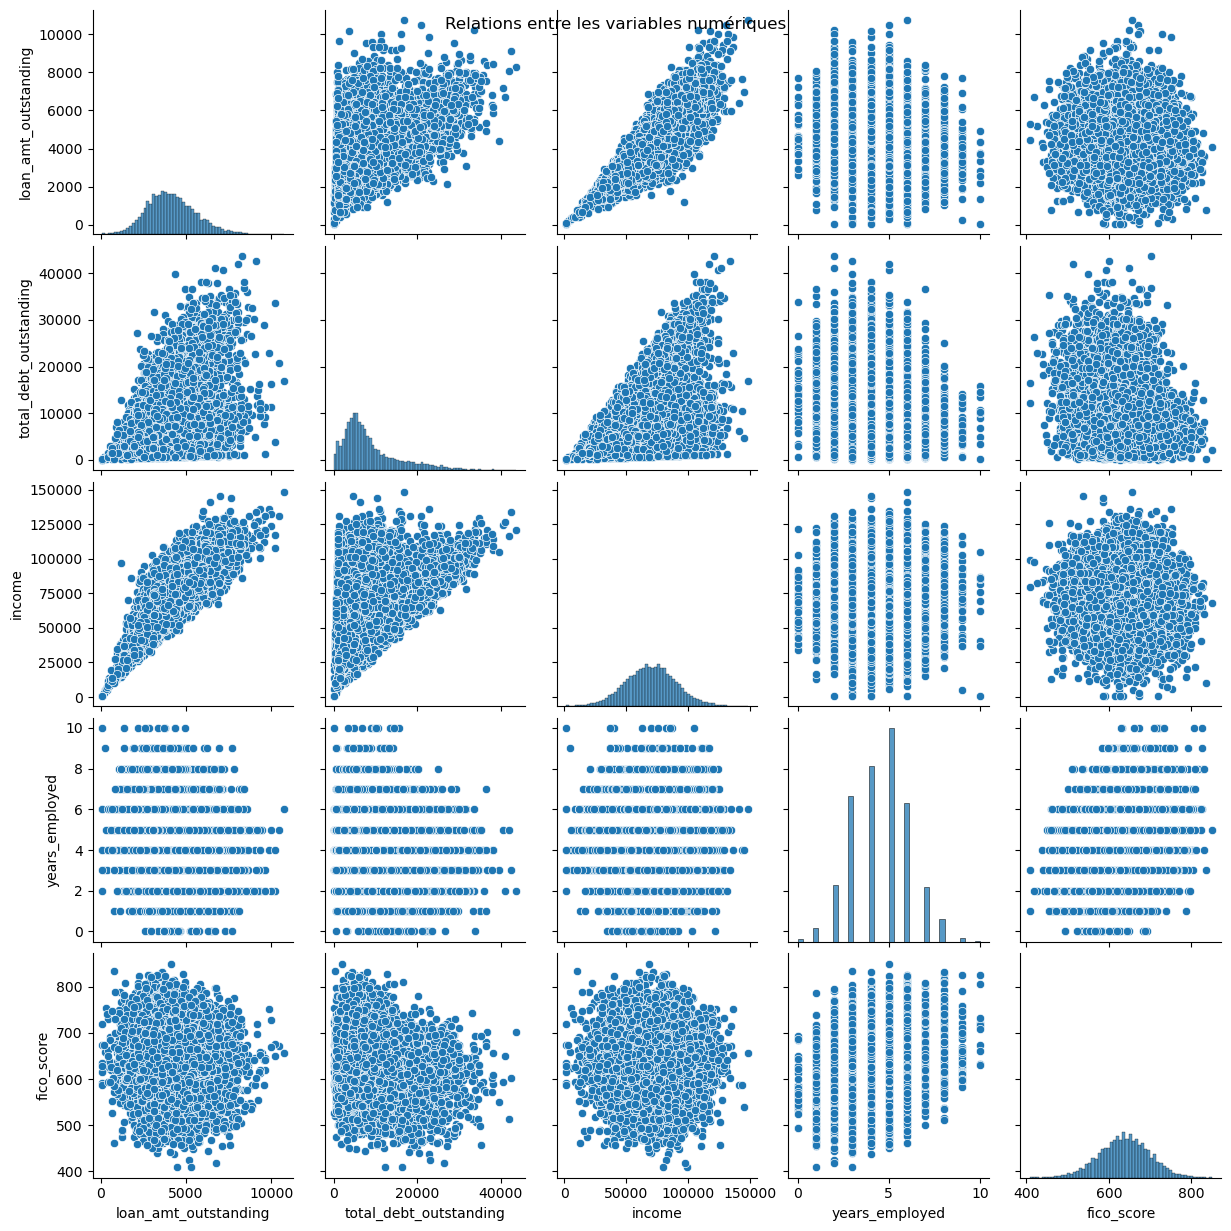

In [16]:
sns.pairplot(data[numeric_columns])
plt.suptitle("Relations entre les variables numériques")
plt.show()

In [10]:

# Fonction pour évaluer les performances du modèle
from sklearn.pipeline import FunctionTransformer, make_pipeline


def eval_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return accuracy, f1, roc_auc

# Fonction pour gérer les outliers en limitant les valeurs à un certain seuil (1% et 99%)
def cap_outliers(X, lower_quantile=0.01, upper_quantile=0.99):
    X_capped = X.copy()
    for column in X_capped.columns:
        lower_bound = X_capped[column].quantile(lower_quantile)
        upper_bound = X_capped[column].quantile(upper_quantile)
        X_capped[column] = np.clip(X_capped[column], lower_bound, upper_bound)
    return X_capped

# Transformer pour gérer les outliers
cap_outliers_transformer = FunctionTransformer(cap_outliers)

# Fonction pour construire le pipeline avec Random Forest
def build_pipeline_random_forest(algo_ml, handle_outliers=True,num_vars=['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']):
    """
    Construire un pipeline pour Random Forest avec gestion optionnelle des outliers.
    
    Parameters:
        algo_ml: Le modèle de machine learning (ici, Random Forest).
        handle_outliers: Boolean, indiquer si la gestion des outliers doit être appliquée.
    """
    if handle_outliers:
        numeric_transformer = make_pipeline(cap_outliers_transformer)  # Gestion des outliers
    else:
        numeric_transformer = make_pipeline()  # Pas de traitement d'outliers

    # Combinaison des transformations dans un ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_vars)  # Colonnes numériques sans la variable cible
        ]
    )
    
    # Pipeline final sans SMOTE
    model = Pipeline(steps=[('preprocessing', preprocessor),
                            ('regressor', algo_ml)])
  
    return model


In [33]:

# Définir les colonnes numériques

# Préparer les données (X : features, y : target)
mlflow.set_experiment("Random_Forest_Experiment")


# Définir les colonnes numériques sans la colonne 'default'
num_vars = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']

# Séparer les données : X sans la colonne 'default', y est la colonne 'default'
X = X_data  # Tes données sans la colonne 'default'
y = y_data  # La colonne 'default' est la variable cible

# Diviser les données en entraînement, validation et test
seed = 4321
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)

# Convertir les colonnes entières en float64 si elles peuvent contenir des valeurs manquantes
X_train = X_train.astype({col: 'float64' for col in X_train.select_dtypes(include='int').columns})
X_test = X_test.astype({col: 'float64' for col in X_test.select_dtypes(include='int').columns})
# Appliquer SMOTE pour équilibrer les classes avant d'entraîner le modèle
smote = SMOTE(sampling_strategy='auto', random_state=seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Activation du suivi automatique pour Sklearn avec MLflow
mlflow.sklearn.autolog()


# Configuration des différents runs avec ou sans SMOTE et avec ou sans gestion des outliers
runs = [
    {"n_estimators": 200, "max_depth": 15, "min_samples_split": 5, "max_features": 'sqrt', "run_name": "rf_200_trees_depth_15_split_5", "use_smote": True, "handle_outliers": True},
    {"n_estimators": 300, "max_depth": 20, "min_samples_split": 5, "max_features": 'log2', "run_name": "rf_300_trees_depth_20_split_5", "use_smote": True, "handle_outliers": True},
    {"n_estimators": 250, "max_depth": 18, "min_samples_split": 2, "max_features": 'sqrt', "run_name": "rf_250_trees_depth_18_split_2", "use_smote": True, "handle_outliers": True},
    {"n_estimators": 200, "max_depth": 15, "min_samples_split": 5, "max_features": 'sqrt', "run_name": "rf_no_smote_no_outliers", "use_smote": False, "handle_outliers": False},  # Sans SMOTE et sans outliers
]

# Boucle pour entraîner différents modèles avec des hyperparamètres optimisés
for run in runs:
    with mlflow.start_run(run_name=run["run_name"]):
        
        # Construire le pipeline avec Random Forest et les hyperparamètres spécifiques
        model = build_pipeline_random_forest(
            algo_ml=RandomForestClassifier(
                random_state=seed, 
                n_estimators=run["n_estimators"], 
                max_depth=run["max_depth"], 
                min_samples_split=run["min_samples_split"], 
                max_features=run["max_features"],  # Correction du paramètre ici
                class_weight="balanced"  # Gestion du déséquilibre des classes dans le modèle
            )
        )
        
        # Entraîner le pipeline modèle sur les données après SMOTE
        model.fit(X_train_smote, y_train_smote)
        
        # Prédictions sur les données d'entraînement
        train_preds = model.predict(X_train_smote)
        
        # Métriques de performances sur les données d'entraînement
        train_accuracy, train_f1, train_roc_auc = eval_metrics(y_train_smote, train_preds)
        
        # Prédictions sur les données de validation
        val_preds = model.predict(X_val)
        
        # Métriques de performances sur les données de validation
        val_accuracy, val_f1, val_roc_auc = eval_metrics(y_val, val_preds)
        
        # Enregistrement des métriques dans MLflow
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("train_roc_auc", train_roc_auc)
        mlflow.log_metric("val_accuracy", val_accuracy)
        mlflow.log_metric("val_f1", val_f1)
        mlflow.log_metric("val_roc_auc", val_roc_auc)
        
        # Sauvegarder le modèle dans MLflow
        mlflow.sklearn.log_model(model, run["run_name"])
        
        # Afficher les résultats pour chaque run
        print(f"Accuracy on Train Data ({run['run_name']}):", train_accuracy)
        print(f"Accuracy on Validation Data ({run['run_name']}):", val_accuracy)
        print(f"F1 Score on Train Data ({run['run_name']}):", train_f1)
        print(f"F1 Score on Validation Data ({run['run_name']}):", val_f1)
        print(f"ROC AUC on Train Data ({run['run_name']}):", train_roc_auc)
        print(f"ROC AUC on Validation Data ({run['run_name']}):", val_roc_auc)
        print("Model run ID: ", mlflow.active_run().info.run_id)
        
# Fin de la session MLflow
mlflow.end_run()

2024/09/08 10:39:30 INFO mlflow.tracking.fluent: Experiment with name 'Random_Forest_Experiment' does not exist. Creating a new experiment.
2024/09/08 10:39:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c32fc726fa2442fa9e77d1c01a51f642', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/09/08 10:39:30 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/09/08 10:39:30 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/09/08 10:39:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/09/08 10:39:33 WARNING mlflow.models.model: Mod

Accuracy on Train Data (rf_200_trees_depth_15_split_5): 1.0
Accuracy on Validation Data (rf_200_trees_depth_15_split_5): 0.9945
F1 Score on Train Data (rf_200_trees_depth_15_split_5): 1.0
F1 Score on Validation Data (rf_200_trees_depth_15_split_5): 0.986232790988736
ROC AUC on Train Data (rf_200_trees_depth_15_split_5): 1.0
ROC AUC on Validation Data (rf_200_trees_depth_15_split_5): 0.9909374999999999
Model run ID:  f290f0f043c54e1ea8e6b3fdfa7aec1d


2024/09/08 10:39:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/fatimetouzeine/anaconda3/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/09/08 10:39:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter wh

Accuracy on Train Data (rf_300_trees_depth_20_split_5): 1.0
Accuracy on Validation Data (rf_300_trees_depth_20_split_5): 0.9945
F1 Score on Train Data (rf_300_trees_depth_20_split_5): 1.0
F1 Score on Validation Data (rf_300_trees_depth_20_split_5): 0.986232790988736
ROC AUC on Train Data (rf_300_trees_depth_20_split_5): 1.0
ROC AUC on Validation Data (rf_300_trees_depth_20_split_5): 0.9909374999999999
Model run ID:  3548ed5115a74b8e886a7850692d3b87


2024/09/08 10:39:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/fatimetouzeine/anaconda3/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/09/08 10:39:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter wh

Accuracy on Train Data (rf_250_trees_depth_18_split_2): 1.0
Accuracy on Validation Data (rf_250_trees_depth_18_split_2): 0.994
F1 Score on Train Data (rf_250_trees_depth_18_split_2): 1.0
F1 Score on Validation Data (rf_250_trees_depth_18_split_2): 0.9849246231155779
ROC AUC on Train Data (rf_250_trees_depth_18_split_2): 1.0
ROC AUC on Validation Data (rf_250_trees_depth_18_split_2): 0.9887500000000001
Model run ID:  887a772c4d534560b9873aa8d5fb92de


2024/09/08 10:39:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/fatimetouzeine/anaconda3/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/09/08 10:40:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter wh

Accuracy on Train Data (rf_no_smote_no_outliers): 1.0
Accuracy on Validation Data (rf_no_smote_no_outliers): 0.9945
F1 Score on Train Data (rf_no_smote_no_outliers): 1.0
F1 Score on Validation Data (rf_no_smote_no_outliers): 0.986232790988736
ROC AUC on Train Data (rf_no_smote_no_outliers): 1.0
ROC AUC on Validation Data (rf_no_smote_no_outliers): 0.9909374999999999
Model run ID:  18944a2c551544f98b1b7d5e130a1fda


In [13]:
# Nombre de lignes dans X_train, X_test et X_train_smote
print("Nombre de lignes dans X_train :", X_train.shape[0])
print("Nombre de lignes dans X_test :", X_test.shape[0])
print("Nombre de lignes dans X_train_smote :", X_train_smote.shape[0])


Nombre de lignes dans X_train : 6000
Nombre de lignes dans X_test : 2000
Nombre de lignes dans X_train_smote : 9820


In [14]:
print("Nombre de lignes dans X_train :", X_data.shape[0])


Nombre de lignes dans X_train : 10000


In [15]:
# 1. Statistiques descriptives avant cap_outliers
print("Statistiques descriptives avant cap_outliers:")
print(X_train.describe())

# 2. Appliquer la fonction cap_outliers
X_train_capped = cap_outliers(X_train)

# 3. Statistiques descriptives après cap_outliers
print("\nStatistiques descriptives après cap_outliers:")
print(X_train_capped.describe())

Statistiques descriptives avant cap_outliers:
        customer_id  credit_lines_outstanding  loan_amt_outstanding  \
count  6.000000e+03               6000.000000           6000.000000   
mean   4.970295e+06                  1.459167           4173.157827   
std    2.293061e+06                  1.732195           1417.267141   
min    1.001679e+06                  0.000000             46.783973   
25%    2.957810e+06                  0.000000           3173.989520   
50%    4.998448e+06                  1.000000           4057.496504   
75%    6.950872e+06                  2.000000           5064.785863   
max    8.999218e+06                  5.000000          10210.746690   

       total_debt_outstanding         income  years_employed   fico_score  
count             6000.000000    6000.000000     6000.000000  6000.000000  
mean              8746.048123   70203.992472        4.564500   638.476000  
std               6603.498873   19833.596913        1.561061    60.389375  
min       

In [34]:
!mlflow server --host 127.0.0.1 --port 8081

[2024-09-08 10:40:12 +0200] [53517] [INFO] Starting gunicorn 23.0.0
[2024-09-08 10:40:12 +0200] [53517] [INFO] Listening at: http://127.0.0.1:8081 (53517)
[2024-09-08 10:40:12 +0200] [53517] [INFO] Using worker: sync
[2024-09-08 10:40:12 +0200] [53518] [INFO] Booting worker with pid: 53518
[2024-09-08 10:40:12 +0200] [53519] [INFO] Booting worker with pid: 53519
[2024-09-08 10:40:12 +0200] [53520] [INFO] Booting worker with pid: 53520
[2024-09-08 10:40:12 +0200] [53521] [INFO] Booting worker with pid: 53521
^C
[2024-09-08 10:41:32 +0200] [53517] [INFO] Handling signal: int
[2024-09-08 10:41:32 +0200] [53518] [INFO] Worker exiting (pid: 53518)
[2024-09-08 10:41:32 +0200] [53520] [INFO] Worker exiting (pid: 53520)
[2024-09-08 10:41:32 +0200] [53519] [INFO] Worker exiting (pid: 53519)
[2024-09-08 10:41:32 +0200] [53521] [INFO] Worker exiting (pid: 53521)


In [37]:
# Définir le nom de l'expérience dans MLflow
mlflow.set_experiment("Logistic_Regression_Experiment")

# Préparer les données (X : features, y : target)
num_vars = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']
X = X_data  # Less données sans la colonne 'default'
y = y_data  # La colonne 'default' est la variable cible

# Diviser les données en entraînement, validation et test
seed = 4321
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)

# Convertir les colonnes entières en float64 si elles peuvent contenir des valeurs manquantes
X_train = X_train.astype({col: 'float64' for col in X_train.select_dtypes(include='int').columns})
X_test = X_test.astype({col: 'float64' for col in X_test.select_dtypes(include='int').columns})

# Appliquer SMOTE pour équilibrer les classes avant d'entraîner le modèle
smote = SMOTE(sampling_strategy='auto', random_state=seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Activation du suivi automatique pour Sklearn avec MLflow
mlflow.sklearn.autolog()

# Configuration des runs pour Logistic Regression
logistic_runs = [
    {"C": 1.0, "max_iter": 100, "run_name": "logreg_default", "use_smote": True, "handle_outliers": True},
    {"C": 0.5, "max_iter": 200, "run_name": "logreg_C_0.5_iter_200", "use_smote": True, "handle_outliers": False},
    {"C": 1.0, "max_iter": 100, "run_name": "logreg_no_smote_no_outliers", "use_smote": False, "handle_outliers": False},
]

# Boucle pour entraîner différents modèles avec Logistic Regression
for run in logistic_runs:
    with mlflow.start_run(run_name=run["run_name"]):
        
        # Appliquer SMOTE uniquement si use_smote est True
        if run["use_smote"]:
            smote = SMOTE(sampling_strategy='auto', random_state=seed)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
            print(f"SMOTE applied for {run['run_name']}.")
        else:
            X_train_resampled, y_train_resampled = X_train, y_train
            print(f"SMOTE not applied for {run['run_name']}.")
        
        # Construire le modèle Logistic Regression
        model = LogisticRegression(
            random_state=seed, 
            C=run["C"], 
            max_iter=run["max_iter"],
            class_weight="balanced"  # Gestion du déséquilibre des classes
        )
        
        # Entraîner le modèle sur les données après SMOTE
        model.fit(X_train_resampled, y_train_resampled)
        
        # Prédictions sur les données d'entraînement
        train_preds = model.predict(X_train_resampled)
        
        # Calcul des métriques sur les données d'entraînement
        train_accuracy, train_f1, train_roc_auc = eval_metrics(y_train_resampled, train_preds)
        
        # Prédictions sur les données de validation
        val_preds = model.predict(X_val)
        
        # Calcul des métriques sur les données de validation
        val_accuracy, val_f1, val_roc_auc = eval_metrics(y_val, val_preds)
        
        # Enregistrement des métriques dans MLflow
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("train_roc_auc", train_roc_auc)
        mlflow.log_metric("val_accuracy", val_accuracy)
        mlflow.log_metric("val_f1", val_f1)
        mlflow.log_metric("val_roc_auc", val_roc_auc)
        
        # Sauvegarder le modèle dans MLflow
        mlflow.sklearn.log_model(model, run["run_name"])
        
        # Afficher les résultats pour chaque run
        print(f"Accuracy on Train Data ({run['run_name']}):", train_accuracy)
        print(f"Accuracy on Validation Data ({run['run_name']}):", val_accuracy)
        print(f"F1 Score on Train Data ({run['run_name']}):", train_f1)
        print(f"F1 Score on Validation Data ({run['run_name']}):", val_f1)
        print(f"ROC AUC on Train Data ({run['run_name']}):", train_roc_auc)
        print(f"ROC AUC on Validation Data ({run['run_name']}):", val_roc_auc)
        print("Model run ID: ", mlflow.active_run().info.run_id)
        
# Fin de la session MLflow
mlflow.end_run()

2024/09/08 10:46:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '114edfb305714ed4b3ee63de913495d4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/09/08 10:46:17 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/09/08 10:46:17 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/09/08 10:46:17 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/09/08 10:46:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu